# A/B Testing
## using a 2 sample Z test because the sample size is over 30

In [ ]:
## from a tutorial posted here: https://github.com/renatofillinich/ab_test_guide_in_python/blob/master/AB%20testing%20with%20Python.ipynb
## using the A/B Testing dataset on Kaggle found here: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [2]:
# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [3]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [5]:
#to load csv
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
#to see if there are any missing values
print(df.shape)
df.isnull().sum()

(294478, 5)


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
#294,478 rows in the dataframe with 5 columns
#user_id - The user ID of each session
#timestamp - Timestamp for the session
#group - Which group the user was assigned to for that session {control, treatment}
#landing_page - Which design each user saw on that session {old_page, new_page}
#converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [11]:
#to check to see if anyone was sampled more than once
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset.')

There are 0 users that appear multiple times in the dataset.


In [12]:
#So out of the 294,478 rows, 3,894 users were sampled more than once.
#To delete them from the dataset...
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries.')

The updated dataset now has 286690 entries.


# Sampling
### using an n = 4720 and random state of 22

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [14]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,43:17.2,control,old_page,0
1,690555,38:13.1,control,old_page,0
2,861520,13:40.0,control,old_page,0
3,630778,42:37.0,control,old_page,0
4,656634,31:21.7,control,old_page,0
...,...,...,...,...,...
9435,908512,02:29.9,treatment,new_page,0
9436,873211,57:16.2,treatment,new_page,0
9437,631276,56:58.2,treatment,new_page,0
9438,662301,10:57.8,treatment,new_page,0


In [15]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [16]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

# Visualize and Interpret the results

In [17]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


In [18]:
# Looking at the results, both the control and treatment groups converted closely
# with the treatement group having a better (higher) conversion rate of 12.6%

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


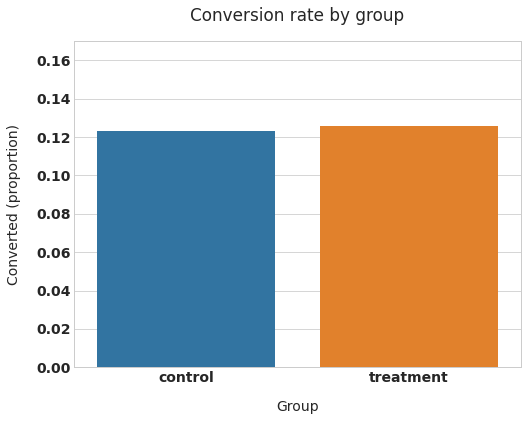

In [19]:
#plot the data with a barchart
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

# Now we need to find out if there is a statistical signficance
# between the two groups
# and test our hypothesis using a z-test

In [20]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [21]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [22]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


In [23]:
#Our p-value of 0.732 is above our alpha of 0.05,
#so we cannot reject the null hypothesis (which was that the groups are the same, or
#that the two groups performed the same when it came to converting users
#So our new design is not an improvment on our old design